# 은행 데이터 분석과 파산 가능성 예측

### 데이터 분석 목적
- 은행별 운영 데이터를 분석하여 파산 가능성을 예측한다
- 이를 이용해 은행별 신용도를 파악하고, 기업 운영 자금 조달 및 보관할 때 활용한다

### Key Point
- Anomaly Detection과 같이 매우 imbalanced data set을 탐색하고 분석하는 방법을 배운다
- 통계적 검정을 통한 feature selection 방법을 배운다
- Anomaly Detection을 다양한 방법으로 푸는 방법에 대해 배운다


In [ ]:
!pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime
import random

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from scipy.stats import boxcox, norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols

# library for sampling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

# library for machine learning
import sklearn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import shap
%matplotlib inline

## 1. Data Processing 1

### 1-1 Data Load

In [ ]:
!pwd
path_lecture = "./drive/MyDrive/MLSignature/Lecture/Part4/ch41/"
random_state = 1234

/content


In [ ]:
df = pd.read_csv(path_lecture + "data/data.csv")
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


### 1-2 Duplicated Data 확인

In [ ]:
print("중복된 항목 수 :", len(df[df.duplicated()]))

중복된 항목 수 : 0


## 2. Data EDA

### 2-1 Data Type and Summary

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
# column name에 불필요한 공백이 추가되어 있음
# 제거 필요
list_new_column = []
for column_name in df.columns:
  new_column_name = column_name
  if column_name[0] == " ":
    new_column_name = new_column_name[1:]
  list_new_column.append(new_column_name)
list_new_column

In [ ]:
df.columns = list_new_column

In [ ]:
# categorical and numeric columns
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

Bankrupt? int64 [1 0]
ROA(C) before interest and depreciation before interest float64 [0.37059426 0.46429094 0.42607127 ... 0.47433335 0.54789646 0.49953688]
ROA(A) before interest and % after tax float64 [0.42438945 0.53821413 0.49901875 ... 0.49329481 0.6067379  0.6480048 ]
ROA(B) before interest and depreciation after tax float64 [0.40574977 0.51673002 0.47229509 ... 0.63172547 0.52417153 0.52063815]
Operating Gross Margin float64 [0.60145721 0.61023509 0.60145001 ... 0.60445524 0.61044408 0.62740887]
Realized Sales Gross Margin float64 [0.60145721 0.61023509 0.60136352 ... 0.60601191 0.61316825 0.62740887]
Operating Profit Rate float64 [0.9989692  0.99894598 0.99885735 ... 0.998741   0.99917649 0.9980803 ]
Pre-tax net Interest Rate float64 [0.79688715 0.79738019 0.79640337 ... 0.79741851 0.79711845 0.80198665]
After-tax net Interest Rate float64 [0.80880936 0.80930073 0.80838752 ... 0.8090958  0.80960278 0.81379956]
Non-industry income and expenditure/revenue float64 [0.30264643 0.

In [ ]:
list_cast_object = ["Bankrupt?", "Liability-Assets Flag", "Net Income Flag"]
for column_name in list_cast_object:
  df[column_name] = df[column_name].astype(object)

In [ ]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64']).columns)
target_column = "Bankrupt?"
print(len(df))
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

6819
96
3
93


In [ ]:
df.isna().sum().sort_values(ascending=False)

Bankrupt?                                                  0
ROA(C) before interest and depreciation before interest    0
Total expense/Assets                                       0
Total income/Total expense                                 0
Retained Earnings to Total Assets                          0
                                                          ..
Total Asset Growth Rate                                    0
Continuous Net Profit Growth Rate                          0
Regular Net Profit Growth Rate                             0
After-tax Net Profit Growth Rate                           0
Equity to Liability                                        0
Length: 96, dtype: int64

#### Summary of Data Set
##### - Number of Variables : 96
    categorical variables : 3 (target 포함)
    numeric variables : 93    
##### - Number of observations : 6819
##### - Missing Cells : 0 columns
##### - Duplicated Rows : 0

### 2-2 Dependent(종속) Data Explore

In [ ]:
list_categorical_columns.remove(target_column)

In [ ]:
# pandas function을 활용해서 분포 확인
df[target_column].describe()

count     6819
unique       2
top          0
freq      6599
Name: Bankrupt?, dtype: int64

In [ ]:
# ratio 확인
df[target_column].value_counts()/6819*100

0    96.77372
1     3.22628
Name: Bankrupt?, dtype: float64

<AxesSubplot:xlabel='Bankrupt?', ylabel='count'>

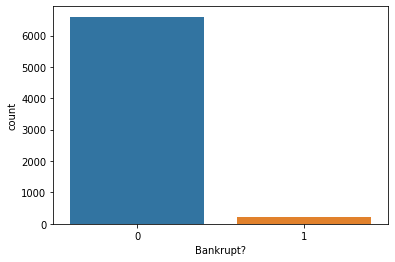

In [ ]:
sns.countplot(x=target_column, data=df)

#### 문제 해결 접근법
1.   Imbalanced Data Set (Normal Classification with Sampling)
2.   Anomaly Detection (Anomaly Detection Classificaiton)



#### 1) Imbalance data set?
  - 두 개 target class 비중 차이가 있다. 독립 변수가 categorical 이 포함된 경우는 one-hot encoding을 진행한 뒤에 sampling(oversampling 혹은 undersampling) 을 해야 한다.
  - 1 속성인 데이터들이 유의미한 데이터 분포와 특성을 갖는다면, 추가적인 sampling 없이 모델 학습이 잘 될 수 있다.
  - ML 학습시 cost-sensitive (class weight 등)을 활용할 수 있다.

##### 1. 데이터 기반 접근 방법
    - Sampling (over sampling)
    (이번 실습에서는 oversampling sampling 중에서 SMOTE 활용)
    https://imbalanced-learn.org/stable/references/index.html#api
##### 2. ML 알고리즘 기반 접근 방법
    - ML 알고리즘 활용 -> ML 학습 시에 class weight를 활용하여 cost-sensitive learning
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### 2) Anomaly Detection
*   Anomaly Detection Algorithm 활용
*   Isolation Forest
*   One-SVM
*   Clustering (Unsupervised Learning)


### 2-3 Independent(독립) Data Explore

#### 1) Categorical Data Analysis

##### 불필요한 컬럼 확인

In [ ]:
df[list_categorical_columns].nunique().sort_values()
# 불필요한 컬럼 보이지 않음

Net Income Flag          1
Liability-Assets Flag    2
dtype: int64

In [ ]:
# Net Income Flag 카운트 확인
df["Net Income Flag"].value_counts()

1    6819
Name: Net Income Flag, dtype: int64

In [ ]:
# Liability-Assets Flag 카운트 확인
df["Liability-Assets Flag"].value_counts()

0    6811
1       8
Name: Liability-Assets Flag, dtype: int64

In [ ]:
# Net Income Flag은 1개 값만 갖기 때문에 제거
df = df.drop(["Net Income Flag"], axis=1)
list_categorical_columns.remove("Net Income Flag")

*    Liability-Assets Flag는 혹시나 1에 속한 8개가 항상 Bankrupcy 1에 해당할 수도 있음 -> 매우 큰 영향력을 발휘
* 위의 부분을 확인한 뒤에 영향력이 있으면 제거하지 않고 영향력이 없으면 제거하기로 결정

<AxesSubplot:xlabel='Liability-Assets Flag'>

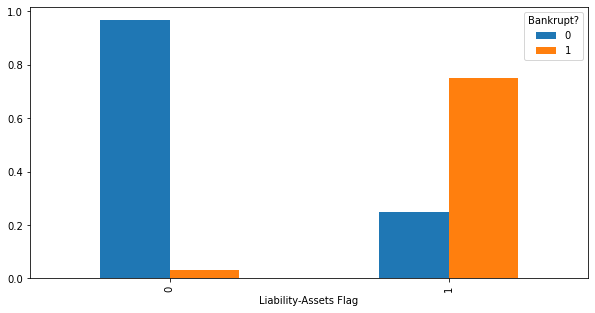

In [ ]:
df_poutcome_dependent_ratio = pd.crosstab(df["Liability-Assets Flag"],df[target_column], normalize="index")
df_poutcome_dependent_ratio.plot.bar(figsize=(10,5))

# 1 값을 가지는 것들이 bankrupt에 속한 것이 약 80%. 제거할 지 여부를 판단하기 쉽지 않음 -> 다른 검정으로 다각적으로 판단 필요

##### 카이제곱 검정 (chisqaure-test)
*   카이제곱 검정은 두 범주형 변수에 대한 분석 방법.
*   예를 들어, 성별에 따른 선호 영화 장르 비교 문제.
*   본 실습에서는 독립 변수중의 categorical column data와 y 간의 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/카이제곱_검정



##### 카이제곱 검정 추가 설명 : 3가지 유형
1.   적합도 검정 (Goodness of fit)
  - 변수 1개
  - 기존에 알려준 기준이 존재하는 검정
  - 예시) 상자 안에 공 3개가 같은 비율로 알려져 있음. 공 100개를 뽑았을 때, 각 색의 비율이 구해짐. -> 기존에 알려진 공 비율 분포를 따르는지 검정
  - 귀무가설 : 변수 X의 관측분포와 기대 분포가 동일
  - 대립가설 : 변수 X의 관측분포와 기대분포가 동일

2.   독립성 검정 (Test of independence)
  - 변수 2개
  - 범주형 두 변수가 서로 연관되어 있는지 여부를 검정
  - 예시) 성별과 흡연 여부 관계를 알고 싶어서 200명을 추출하여 조사한 경우.
  - 귀무가설 : 변수 X와 Y는 서로 독립
  - 대립가설 : 변수 X와 Y는 서로 독립이 아님
3.   동질성 검정 (Test of Homogeneity)
  - 변수 2개
  - 범주형 두 변수의 관계를 알기 위한 검정은 아님
  - 각 그룹들이 동질한지 알고 싶은 검정
  - 예시) 남자와 여자 흡연율 차이가 있는지 흡연율을 조사한 후, 두 그룹의 흡연율이 같은지 여부를 검정
  - 귀무가설 : 각 그룹의 확률분포가 동일
  - 대립가설 : 각 그룹의 확률분포가 동일하지 않음




In [ ]:
statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df["Liability-Assets Flag"]))
print(statistic, pvalue)

110.13807127769104 9.139776609482457e-26


##### Insight
1.   y(종속 변수)와 categorical data 1개가 유의미한 관계를 갖음



#### 2) Numeric Data Analysis

##### 불필요한 컬럼 확인

In [ ]:
df[list_numeric_columns].nunique().sort_values()

Total Asset Turnover                        381
Net Worth Turnover Rate (times)             741
Interest-bearing debt interest rate        1080
Operating Profit Per Share (Yuan ¥)        1236
Persistent EPS in the Last Four Seasons    1358
                                           ... 
Current Assets/Total Assets                6819
Quick Assets/Total Assets                  6819
Working Capital to Total Assets            6819
Current Liability to Equity                6819
Equity to Liability                        6819
Length: 93, dtype: int64

In [ ]:
df[list_numeric_columns].describe().to_csv(path_lecture+"data/describe.csv")

##### Column별 분포 확인

In [ ]:
# 컬럼별 skewness, kurtosis 확인 진행
for column_name in list_numeric_columns:
  print(column_name, "skew : ", skew(df[column_name]), "kurtosis : ", kurtosis(df[column_name]))

# 추후 scaling을 활용한 feature preprocessing의 필요성 확인

ROA(C) before interest and depreciation before interest skew :  -0.323869740413385 kurtosis :  6.385205395841394
ROA(A) before interest and % after tax skew :  -1.0334994309305 kurtosis :  9.031278783842245
ROA(B) before interest and depreciation after tax skew :  -0.7633957450523285 kurtosis :  7.922381193456117
Operating Gross Margin skew :  -8.041598526220652 kurtosis :  365.2718156244965
Realized Sales Gross Margin skew :  -8.064797602261708 kurtosis :  366.7718734856533
Operating Profit Rate skew :  -70.22171309499203 kurtosis :  5206.26569057916
Pre-tax net Interest Rate skew :  -52.47132097204325 kurtosis :  3050.7943067267565
After-tax net Interest Rate skew :  -52.98408543751869 kurtosis :  3026.8942816717454
Non-industry income and expenditure/revenue skew :  39.63296852945884 kurtosis :  2647.4855593046036
Continuous interest rate (after tax) skew :  -53.18841745374395 kurtosis :  3126.439638623958
Operating Expense Rate skew :  1.2483986246061325 kurtosis :  -0.082331678313

##### Correlation Analysis

<AxesSubplot:>

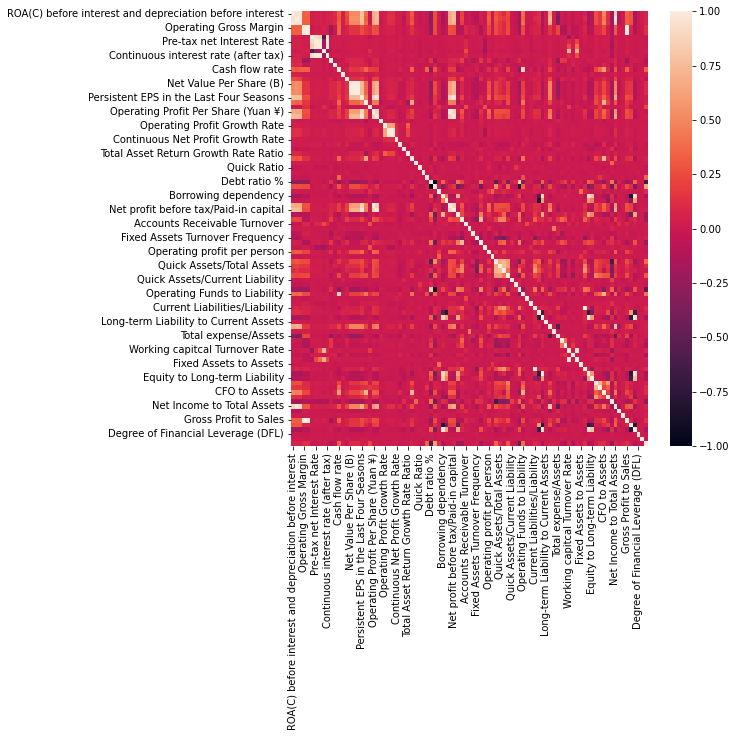

In [ ]:
df_corr = df[list_numeric_columns].corr()
plt.figure(figsize=(8,8))
sns.heatmap(df_corr)

In [ ]:
# 너무 높은 correlation을 갖는 데이터를 삭제. 단, 해당 correlation값을 신뢰할 수 있는지 확인필요
# 기준은 절대값 0.85 이상
index_corr_over_85 = np.where((abs(df_corr) > 0.85) & (df_corr != 1))
index_corr_over_85

# 너무 많기 때문에, 판단하기 어려움 -> vif 분석으로 double check하면서 제외할 feature 선택

(array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  5,  5,  5,  6,
         6,  6,  7,  7,  7,  9,  9,  9, 12, 15, 15, 16, 16, 17, 17, 18, 18,
        18, 18, 21, 21, 21, 21, 22, 22, 22, 22, 25, 26, 36, 37, 39, 39, 39,
        41, 41, 41, 41, 42, 42, 42, 42, 60, 65, 65, 72, 74, 77, 77, 84, 84,
        84, 87, 87, 89, 89, 89]),
 array([ 1,  2, 84,  0,  2, 84,  0,  1, 84,  4, 87,  3, 87,  6,  7,  9,  5,
         7,  9,  5,  6,  9,  5,  6,  7, 60, 16, 17, 15, 17, 15, 16, 21, 22,
        41, 42, 18, 22, 41, 42, 18, 21, 41, 42, 26, 25, 37, 36, 65, 77, 89,
        18, 21, 22, 42, 18, 21, 22, 41, 12, 39, 89, 74, 72, 39, 89,  0,  1,
         2,  3,  4, 39, 65, 77]))

##### VIF Analysis
-   일반적으로는는 10이상인 경우 다중공선성이이 있다고 가정. 본 실습에서는 30이상인 경우를 기준으로 잡음(너무 많은 데이터가 제거되면 비선형적인 관계를 갖고 있던 데이터 특성이 모두 제거 될 수 있으니 적정한 기준을 잡아 진행)
-   high correlation 컬럼을 제거하기 전에 한 번 더 검정을 진행 (doublecheck, 개인의 판단에 따라서 진행하지 않아도됨)

In [ ]:
# caculate_vif 함수 구현
def caculate_vif(df_target):
  df_vif = pd.DataFrame()
  df_vif["VIF_Factor"] = [variance_inflation_factor(df_target.values, i) for i in range(df_target.shape[1])]
  df_vif["Feature"] = df_target.columns
  return df_vif

In [ ]:
df_vif_result = caculate_vif(df[list_numeric_columns])
df_vif_result

,VIF_Factor,Feature
0,6.901849e+01,ROA(C) before interest and depreciation before...
1,4.359547e+01,ROA(A) before interest and % after tax
2,1.028945e+02,ROA(B) before interest and depreciation after tax
3,5.174663e+07,Operating Gross Margin
4,1.076293e+03,Realized Sales Gross Margin
...,...,...
88,8.349086e+00,Net Income to Stockholder's Equity
89,4.649451e+02,Liability to Equity
90,1.004899e+00,Degree of Financial Leverage (DFL)
91,1.006981e+00,Interest Coverage Ratio (Interest expense to E...


In [ ]:
df_vif_result[df_vif_result.VIF_Factor >= 30].sort_values(by=["VIF_Factor"], ascending=False)

,VIF_Factor,Feature
76,1.822139e+11,Current Liability to Liability
63,7.696580e+09,Current Liabilities/Liability
53,7.635116e+09,Working Capital to Total Assets
37,2.872880e+09,Net worth/Assets
55,2.524199e+09,Current Assets/Total Assets
77,2.098054e+09,Current Liability to Equity
59,1.910686e+09,Current Liability to Assets
36,1.831979e+09,Debt ratio %
65,1.089568e+09,Current Liabilities/Equity
5,4.329753e+08,Operating Profit Rate


In [ ]:
dropping_list_by_vif = list(df_vif_result[df_vif_result.VIF_Factor >= 30].sort_values(by=["VIF_Factor"], ascending=False).Feature)
print(len(dropping_list_by_vif))

36


In [ ]:
caculate_vif(df[list_numeric_columns].drop(columns=dropping_list_by_vif)).sort_values(by=["VIF_Factor"], ascending=False)

,VIF_Factor,Feature
34,6.989107,Operating Funds to Liability
48,6.596035,CFO to Assets
51,5.084170,Net Income to Total Assets
2,5.032652,Cash flow rate
21,4.295327,Total Asset Turnover
46,4.067136,Cash Flow to Total Assets
5,3.630042,Cash Flow Per Share
26,3.326023,Net Worth Turnover Rate (times)
14,3.001040,Cash Reinvestment %
7,2.942825,Per Share Net profit before tax (Yuan ¥)


In [ ]:
list_numeric_by_vif = list(set(list_numeric_columns) - set(dropping_list_by_vif))
print(len(list_numeric_by_vif))

57


##### Target Column과 numeric Column 관계 분포 확인

In [ ]:
# 랜덤하게 numerical data 선택
list_numeric_randomly = random.sample(list_numeric_by_vif, 16)

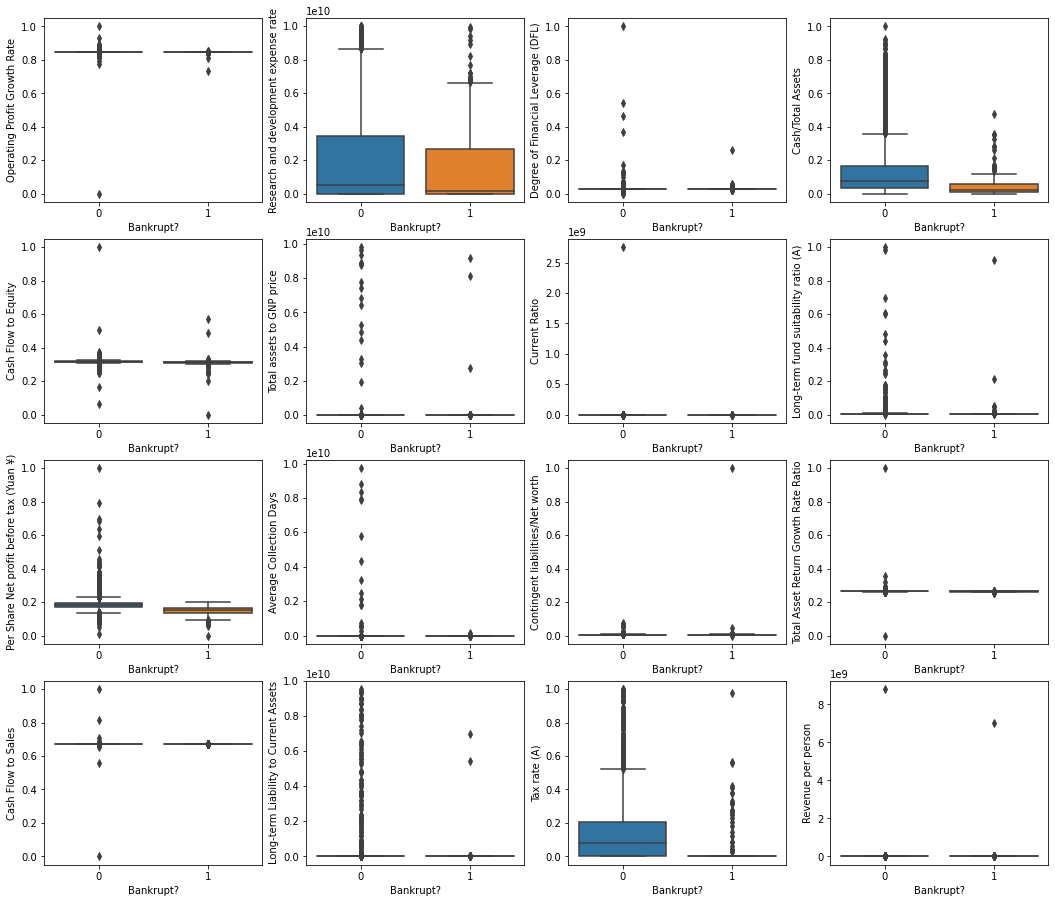

In [ ]:
plt.figure(figsize=(18,12))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_randomly:
    plt.subplot(4,4,x)
    x = x + 1
    sns.boxplot(data=df,x=target_column,y=column_name)
plt.show()

# 두 데이터의 분포가 너무 많이 차이가 나기떄문에, 아래와 같은 분포 차이를 그려도 제대로 데이터를 이해하기 어려움.

##### 크루스칼 왈리스 검정 Kruskall-Wallis test (비모수 검정)
*   비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도됨
*   단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐
*   본 실습에서는 크루스칼 왈리스 검정을 더욱 신뢰하기는 어려우나, 두 변수간의 연관성이 없다고 판단되는 거은 신뢰할만함. 우리가 가진 데이터(모델 학습을 위한)는 현재 데이터 뿐이기 때문에(즉, 우리가 가진 데이터는 이것이 전부이기 때문에) 연관성이 없으면 제외해도 된다고 판단 할 수 있음

In [ ]:
list_target_unique = df[target_column].unique()
list_meaningful_column_by_kruskall = []

for column_name in list_numeric_by_vif:
  list_by_quality_value = []
  for quality_value in list_target_unique:
      df_tmp = df[df[target_column] == quality_value][column_name].dropna()
      list_by_quality_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_quality_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all numerical columns : ", len(list_numeric_by_vif))
print("selected columns by kruskal : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

Retained Earnings to Total Assets ,  359.20986077198904 ,  4.184417610354488e-80
Per Share Net profit before tax (Yuan ¥) ,  368.3705937267394 ,  4.236121853675956e-82
Revenue Per Share (Yuan ¥) ,  38.287473465461844 ,  6.105330542469813e-10
Quick Asset Turnover Rate ,  9.306722867661353 ,  0.00228314503063887
Cash/Current Liability ,  146.83488543910167 ,  8.52758830995915e-34
Net Income to Stockholder's Equity ,  327.1680021689608 ,  3.977481879966969e-73
Inventory/Working Capital ,  21.03076603782058 ,  4.5196717639698115e-06
Cash Flow to Liability ,  42.76658667735683 ,  6.167669629872154e-11
Operating profit per person ,  206.886804719993 ,  6.562970071970647e-47
Contingent liabilities/Net worth ,  6.642451618550415 ,  0.009957680994390481
Average Collection Days ,  4.742336471853225 ,  0.029429077115038636
CFO to Assets ,  113.81765796414038 ,  1.428596320305038e-26
Inventory/Current Liability ,  21.681205685128685 ,  3.2192996840379585e-06
Cash Flow to Sales ,  59.43194932712868

##### Insight
1.   상관관계가 매우 높으면서 VIF도 높은 변수가 존재하여 그런 데이터를 제거 진행
2.   크루스칼 검정을 모두 신뢰하기 어려운 데이터 분포이지만(연관성이 있다라는 사실에 대해서), 연관성이 없다라고 판단된 데이터는 신뢰할 만함. 이유는 우리가 가진 데이터가 이것뿐이기 때문에 현 데이터로 연관성이 없으면 제거하도 문제되지 않을 확률이 높음

## 3. Data Processing 2

### 3-1 Feature Selection
*   카이제곱 검정을 통과한 categorical 선택
*   kruskall 검정 통과한 numerical 선택
*   VIF 분석에서 factor value 높은 컬럼 제거


In [ ]:
df_fs = df[list_categorical_columns+list_meaningful_column_by_kruskall + [target_column]]
df_fs.head(2)

,Liability-Assets Flag,Retained Earnings to Total Assets,Per Share Net profit before tax (Yuan ¥),Revenue Per Share (Yuan ¥),Quick Asset Turnover Rate,Cash/Current Liability,Net Income to Stockholder's Equity,Inventory/Working Capital,Cash Flow to Liability,Operating profit per person,...,Long-term Liability to Current Assets,Tax rate (A),Interest Coverage Ratio (Interest expense to EBIT),Interest Expense Ratio,Total Asset Growth Rate,Total income/Total expense,Total assets to GNP price,Interest-bearing debt interest rate,Cash Flow to Total Assets,Bankrupt?
0,0,0.903225,0.138736,0.017560,6.550000e+09,0.000147,0.827890,0.276920,0.458609,0.392913,...,0.025592,0.0,0.564050,0.629951,4.980000e+09,0.002022,0.009219,0.000725,0.637555,1
1,0,0.931065,0.169918,0.021144,7.700000e+09,0.001384,0.839969,0.289642,0.459001,0.391590,...,0.023947,0.0,0.570175,0.635172,6.110000e+09,0.002226,0.008323,0.000647,0.641100,1


### 3-2 Missing Values

In [ ]:
df_fs.isna().sum().sort_values(ascending=False)

Liability-Assets Flag                                 0
Total Asset Turnover                                  0
Current Liability to Current Assets                   0
Net Income to Total Assets                            0
Net Value Growth Rate                                 0
Cash Flow Per Share                                   0
Cash/Total Assets                                     0
Research and development expense rate                 0
Continuous Net Profit Growth Rate                     0
Cash Flow to Equity                                   0
Operating Funds to Liability                          0
Current Asset Turnover Rate                           0
Degree of Financial Leverage (DFL)                    0
Fixed Assets to Assets                                0
Allocation rate per person                            0
Cash Reinvestment %                                   0
Long-term Liability to Current Assets                 0
Tax rate (A)                                    

### 3-3 Feature Transformation

In [ ]:
X = df_fs.drop([target_column], axis=1)
Y = df_fs[target_column]

##### Label Encoding

In [ ]:
Y = Y.astype("int")

##### Feature Scaling
*   Standardization과 MinMaxScaling은 다른 것.
*   MinMaxScaling은 [0,1]로 값을 scaling 하는 것 (예 sklearn의 MinMaxScaler())
*   Standardization은 정규분포의 표준화를 활용하여 scaling하는 것 (예 sklearn의 StandardScaler())



In [ ]:
list_categorical_columns_fs = list(X.select_dtypes(include=['object']).columns)
list_numeric_columns_fs = list(X.select_dtypes(include=['float64']).columns)
print(len(list_categorical_columns_fs))
print(len(list_numeric_columns_fs))

1
51


In [ ]:
list_categorical_columns_fs

['Liability-Assets Flag']

In [ ]:
# min max scaling
scaler = MinMaxScaler()
X.loc[:, list_numeric_columns_fs] = scaler.fit_transform(X[list_numeric_columns_fs])
X.head(1)

,Liability-Assets Flag,Retained Earnings to Total Assets,Per Share Net profit before tax (Yuan ¥),Revenue Per Share (Yuan ¥),Quick Asset Turnover Rate,Cash/Current Liability,Net Income to Stockholder's Equity,Inventory/Working Capital,Cash Flow to Liability,Operating profit per person,...,Cash Reinvestment %,Long-term Liability to Current Assets,Tax rate (A),Interest Coverage Ratio (Interest expense to EBIT),Interest Expense Ratio,Total Asset Growth Rate,Total income/Total expense,Total assets to GNP price,Interest-bearing debt interest rate,Cash Flow to Total Assets
0,0,0.903225,0.138736,5.814497e-12,0.655,1.526798e-14,0.82789,0.27692,0.458609,0.392913,...,0.363725,2.682638e-12,0.0,0.56405,0.629951,0.498498,0.002022,9.388432e-13,7.323965e-13,0.637555


##### One-hot Encoding for categorical column data

In [ ]:
X_base = pd.get_dummies(X)
X_base.head(1)

,Retained Earnings to Total Assets,Per Share Net profit before tax (Yuan ¥),Revenue Per Share (Yuan ¥),Quick Asset Turnover Rate,Cash/Current Liability,Net Income to Stockholder's Equity,Inventory/Working Capital,Cash Flow to Liability,Operating profit per person,Contingent liabilities/Net worth,...,Tax rate (A),Interest Coverage Ratio (Interest expense to EBIT),Interest Expense Ratio,Total Asset Growth Rate,Total income/Total expense,Total assets to GNP price,Interest-bearing debt interest rate,Cash Flow to Total Assets,Liability-Assets Flag_0,Liability-Assets Flag_1
0,0.903225,0.138736,5.814497e-12,0.655,1.526798e-14,0.82789,0.27692,0.458609,0.392913,0.006479,...,0.0,0.56405,0.629951,0.498498,0.002022,9.388432e-13,7.323965e-13,0.637555,1,0


### 3-4 Sampling
*   이번 실습에서는 두 가지 oversampling 기법과 combinedsampling 기법을 활용하고, 2 가지로 만들어진 데이터를 활용하여 Model optimization 진행
*   SMOTE : Synthetic Minority Overf-sampling Technique. minority class에서 synthetic sampling을 생성하는 방법. 특정 minority class A에서 knn 기준으로 가까운 minority class Set K를 생성하고, A와 Set K 사이 간에 새로운 관측치를 생성하는 기법.
*   SMOTEENN : SMOTE + ENN



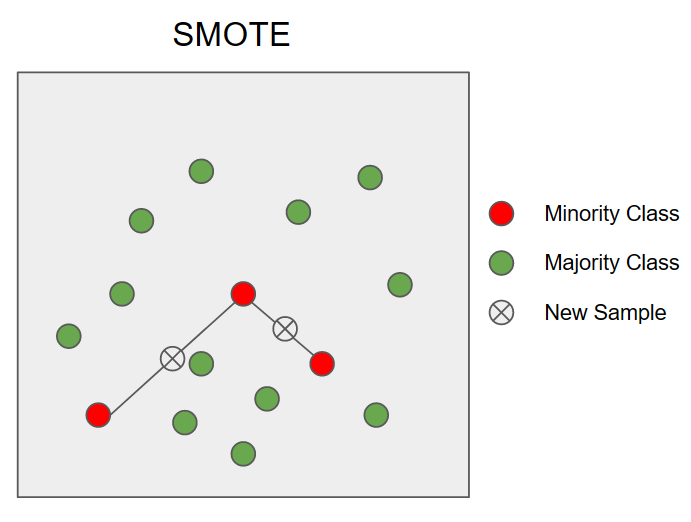

In [ ]:
Image(path_lecture+"img/sampling.png")

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y, test_size=0.2, stratify=Y)

SMOTE

In [ ]:
sm = SMOTE(random_state=random_state)
X_sm_sampling, y_sm_sampling = sm.fit_resample(X_train, y_train)

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 1.0, 'After sampling for target label')

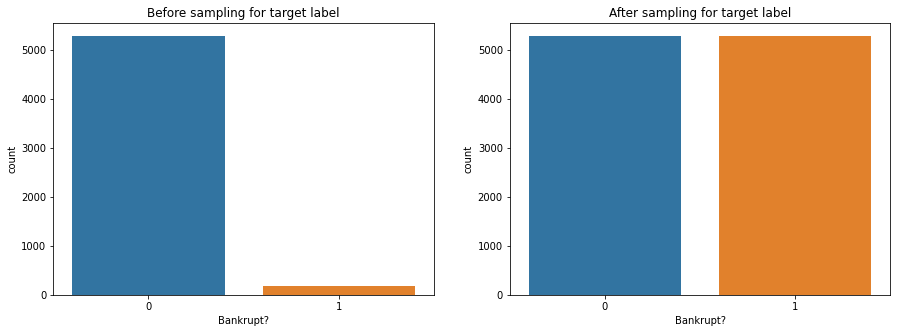

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.countplot(y_train)
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.countplot(y_sm_sampling)
plt.title("After sampling for target label")

SMOTEENN

In [ ]:
# smote enn sampling
combined_sm = SMOTEENN(random_state = random_state)
X_csm_sampling, y_csm_sampling = combined_sm.fit_resample(X_train, y_train)

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 1.0, 'After sampling for target label')

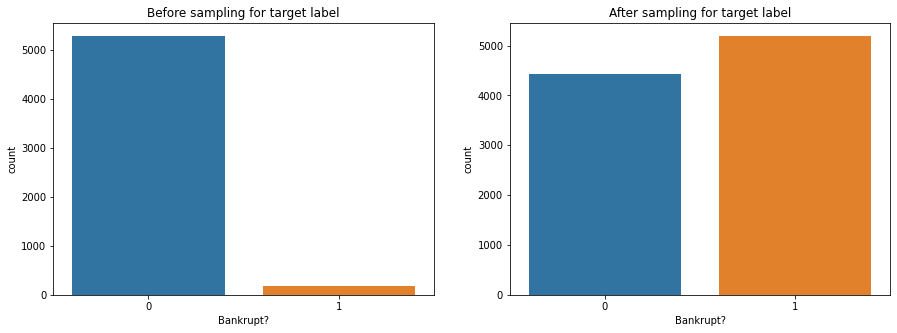

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.countplot(y_train)
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.countplot(y_csm_sampling)
plt.title("After sampling for target label")

### 3-3 Summary
##### 최종 생성 Feature는 아래와 같은 특성을 가짐
1.   Feature Selection by Chi-test, VIF and kruskal-test
2.   Feature Transformation
3.   Sampling (oversampling, combiedsampling)

##### Feature 종류
1.   X_base, Y (No sampling, imbalanced data)
2.   X_sm_sampling, Y_sm_sampling (smote oversampling)
4.   X_csm_sampling, y_csm_sampling (smoteenn combinedsampling)

## 4. Model Analysis
1.   Base model without sampling
2.   Model Optimization without sampling
3.   Isolation Forest Optimization without sampling
4.   model optimization with SMOTE Oversampling
5.   model optimization with SMOTEENN combined sampling

In [ ]:
list_model_type = []
list_model_best_params = []
list_model_f1score = []
cv = 3
n_jobs = -1
n_iter_randomsearch = 16

### 4-1. Base model without sampling

In [ ]:
X_train_npy = np.array(X_train)
y_train_npy = np.array(y_train)

In [ ]:
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_train_npy, y_train_npy)

3

In [ ]:
list_fold_result = []
for i, (train_index, test_index) in enumerate(skf.split(X_train_npy, y_train_npy)):
  X_train_cv, X_test_cv = X_train_npy[train_index], X_train_npy[test_index]
  y_train_cv, y_test_cv = y_train_npy[train_index], y_train_npy[test_index]
  rf_clf = RandomForestClassifier()
  rf_clf.fit(X_train_cv, y_train_cv)
  y_prd_test = rf_clf.predict(X_test_cv)
  y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:,-1]
  prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average="macro")
  score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average="macro")
  print(i, " precision, recall, f1score : ", prf_score_test)
  print(i, " roc_auc_score : ", score_test)

  y_prd_validation = rf_clf.predict(X_validation)
  y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]
  prf_score_validation = precision_recall_fscore_support(y_validation, y_prd_validation, average="macro")
  score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average="macro")
  print("validation : precision, recall, f1score : ",prf_score_validation)
  print("validation : roc_auc_score : ",score_validation)
  list_fold_result.append(prf_score_validation[2])

average_f1score = np.mean(list_fold_result)
print("average f1score : ",average_f1score)
list_model_type.append("Base model without sampling")
list_model_best_params.append({})
list_model_f1score.append(average_f1score)

0  precision, recall, f1score :  (0.7861419068736142, 0.5745666409861325, 0.6137652804319471, None)
0  roc_auc_score :  0.9084071648690293
validation : precision, recall, f1score :  (0.8332004782781985, 0.6007575757575757, 0.6505941003763621, None)
validation : roc_auc_score :  0.9357868457300276


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


1  precision, recall, f1score :  (0.7807917170199563, 0.5842182601880878, 0.6256107834877843, None)
1  roc_auc_score :  0.9108640282131661
validation : precision, recall, f1score :  (0.7586844050258684, 0.5662878787878788, 0.6010475121586233, None)
validation : roc_auc_score :  0.9349690082644628


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


2  precision, recall, f1score :  (0.8858960176991151, 0.5672281053372005, 0.6085128167623506, None)
2  roc_auc_score :  0.9239118913866702
validation : precision, recall, f1score :  (0.8045084996304508, 0.578030303030303, 0.6196034418256641, None)
validation : roc_auc_score :  0.946565082644628
average f1score :  0.6237483514535498


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


- sklearn precision recall f1 support
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

In [ ]:
# show confusion matrix
cm = pd.DataFrame(confusion_matrix(y_validation, y_prd_validation))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

NameError: ignored

### 4-2. Model Optimization without sampling

In [ ]:
def plot_roc_auc(y_true, y_prd_proba):
  fpr, tpr, _ = roc_curve(y_true,  y_prd_proba)
  auc = roc_auc_score(y_true, y_prd_proba)
  plt.figure(figsize=(7,7))
  plt.plot(fpr,tpr,label="auc="+str(auc))
  plt.legend(loc=4)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()

In [ ]:
def model_learning_with_randomsearch(model, hyper_parameter, X, Y, metric="roc_auc_ovr_weighted"):
  random_cv_opt = RandomizedSearchCV(estimator=model, param_distributions=hyper_parameter, n_iter=n_iter_randomsearch, cv = cv, n_jobs = n_jobs, random_state=random_state, scoring=metric, verbose=1)
  random_cv_opt.fit(X, Y)
  # precision recall fscore
  # roc_auc score

  y_prd = random_cv_opt.predict(X_validation)
  prf_score = precision_recall_fscore_support(y_validation, y_prd, average="macro")

  y_prd_proba = random_cv_opt.predict_proba(X_validation)[:,-1]
  score = roc_auc_score(y_validation, y_prd_proba, average='macro')

  print('validation -> best model hyper-parameter : ', random_cv_opt.best_params_)
  print("validation -> precision, recall, f1score : ", prf_score)
  print("validation -> roc_auc_score : ", score)

  cm = pd.DataFrame(confusion_matrix(y_validation,y_prd))
  sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

  return random_cv_opt.best_params_, prf_score, score

Fitting 3 folds for each of 16 candidates, totalling 48 fits
validation -> best model hyper-parameter :  {'max_features': 0.9, 'max_depth': 15, 'class_weight': 'balanced'}
validation -> precision, recall, f1score :  (0.6321534194869907, 0.6977272727272728, 0.6572239033072047, None)
validation -> roc_auc_score :  0.9103994490358127


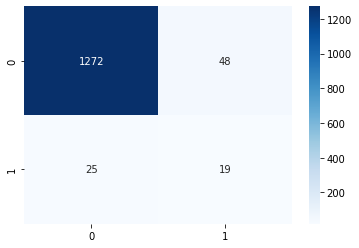

In [ ]:
hyper_params_rlf = {
    "max_depth" : [8, 10, 15, 20],
    "class_weight" : ["balanced", "balanced_subsample"],
    "max_features" : [0.7, 0.8, 0.9]
              }
params, prf_score, score = model_learning_with_randomsearch(RandomForestClassifier(), hyper_params_rlf, X_train, y_train)
list_model_type.append("model optimization without sampling")
list_model_best_params.append(params)
list_model_f1score.append(prf_score[2])

### 4-3. Isolation Forest Optimization without sampling
- 밀도기반 이상 탐지
- 데이터 셋을 Decision Tree 형태로 표현하고, 정상값은 decision tree height가 깊고 이상값은은 decision tree height가 얕아 상단부에서 분리할 수 있다는 것을 이용
- 장점
  - 군집기반 이상 탐지 알고리즘에 비해 계산량이 매우 적음
  - robust한 모델 구현 가능

In [ ]:
def change_prediction_result(y_prd):
  return np.where(y_prd == 1, 0, 1)

if_clf=IsolationForest(n_estimators=100, max_samples='auto', n_jobs=-1, max_features=0.9)
if_clf.fit(X_train)
y_prd = if_clf.predict(X_validation)
# 1 -> normal
# -1 -> anomaly

In [ ]:
y_prd_changed = change_prediction_result(y_prd)
prf_score = precision_recall_fscore_support(y_validation, y_prd_changed, average="macro")

<AxesSubplot:>

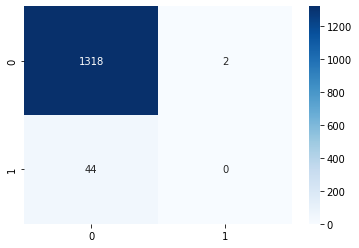

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_validation,y_prd_changed))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

In [ ]:
list_model_type.append("Isolation Forest Optimization without sampling")
list_model_best_params.append({})
list_model_f1score.append(prf_score[2])

### 4-4. model optimization with SMOTE Oversampling

Fitting 3 folds for each of 16 candidates, totalling 48 fits
validation -> best model hyper-parameter :  {'max_features': 0.7, 'max_depth': 20, 'class_weight': 'balanced_subsample'}
validation -> precision, recall, f1score :  (0.641112828438949, 0.7200757575757576, 0.6704385293762333, None)
validation -> roc_auc_score :  0.9084538567493112


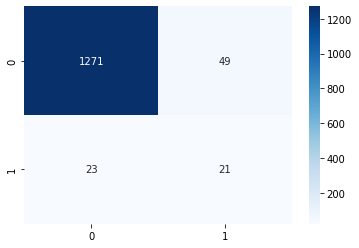

In [ ]:
params, prf_score, score = model_learning_with_randomsearch(RandomForestClassifier(), hyper_params_rlf, X_sm_sampling, y_sm_sampling)
list_model_type.append("model optimization with smote oversampling")
list_model_best_params.append(params)
list_model_f1score.append(prf_score[2])

### 4-5. model optimization with smoteenn combined sampling

Fitting 3 folds for each of 16 candidates, totalling 48 fits
validation -> best model hyper-parameter :  {'max_features': 0.7, 'max_depth': 20, 'class_weight': 'balanced_subsample'}
validation -> precision, recall, f1score :  (0.6099343557444116, 0.7632575757575757, 0.6477263894286825, None)
validation -> roc_auc_score :  0.9227789256198348


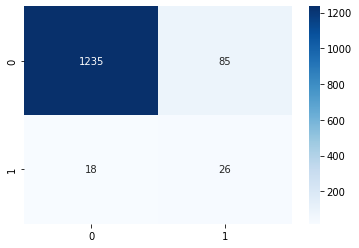

In [ ]:
params, prf_score, score = model_learning_with_randomsearch(RandomForestClassifier(), hyper_params_rlf, X_csm_sampling, y_csm_sampling)
list_model_type.append("model optimization with smoteenn combined oversampling")
list_model_best_params.append(params)
list_model_f1score.append(prf_score[2])

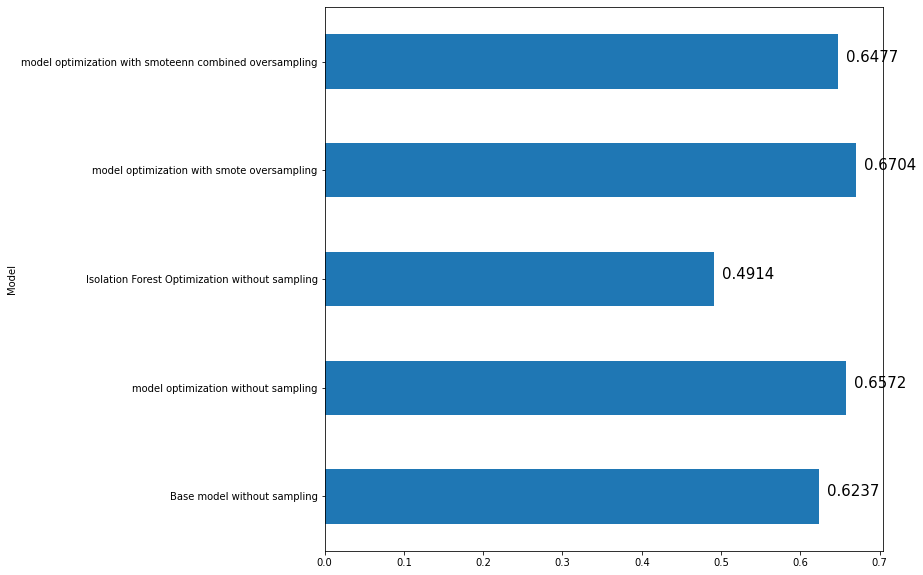

In [ ]:
df_metric = pd.DataFrame({'Model':list_model_type, 'f1score_macro':list_model_f1score})
ax = df_metric.plot.barh(x='Model', y='f1score_macro', rot=0, figsize=(10,10), legend=False)
for bar in ax.patches:
    ax.annotate(format(bar.get_width(), '.4f'),
                   (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                   size=15, xytext=(8, 0),
                   textcoords='offset points')

### 4.6 Model Analysis

In [ ]:
# {'max_features': 0.7, 'max_depth': 20, 'class_weight': 'balanced_subsample'}
# X_sm_sampling, y_sm_sampling

In [ ]:
# reproduction
rf_final = RandomForestClassifier(**{'max_features': 0.7, 'max_depth': 20, 'class_weight': 'balanced_subsample'})
rf_final.fit(X_sm_sampling, y_sm_sampling)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.7)

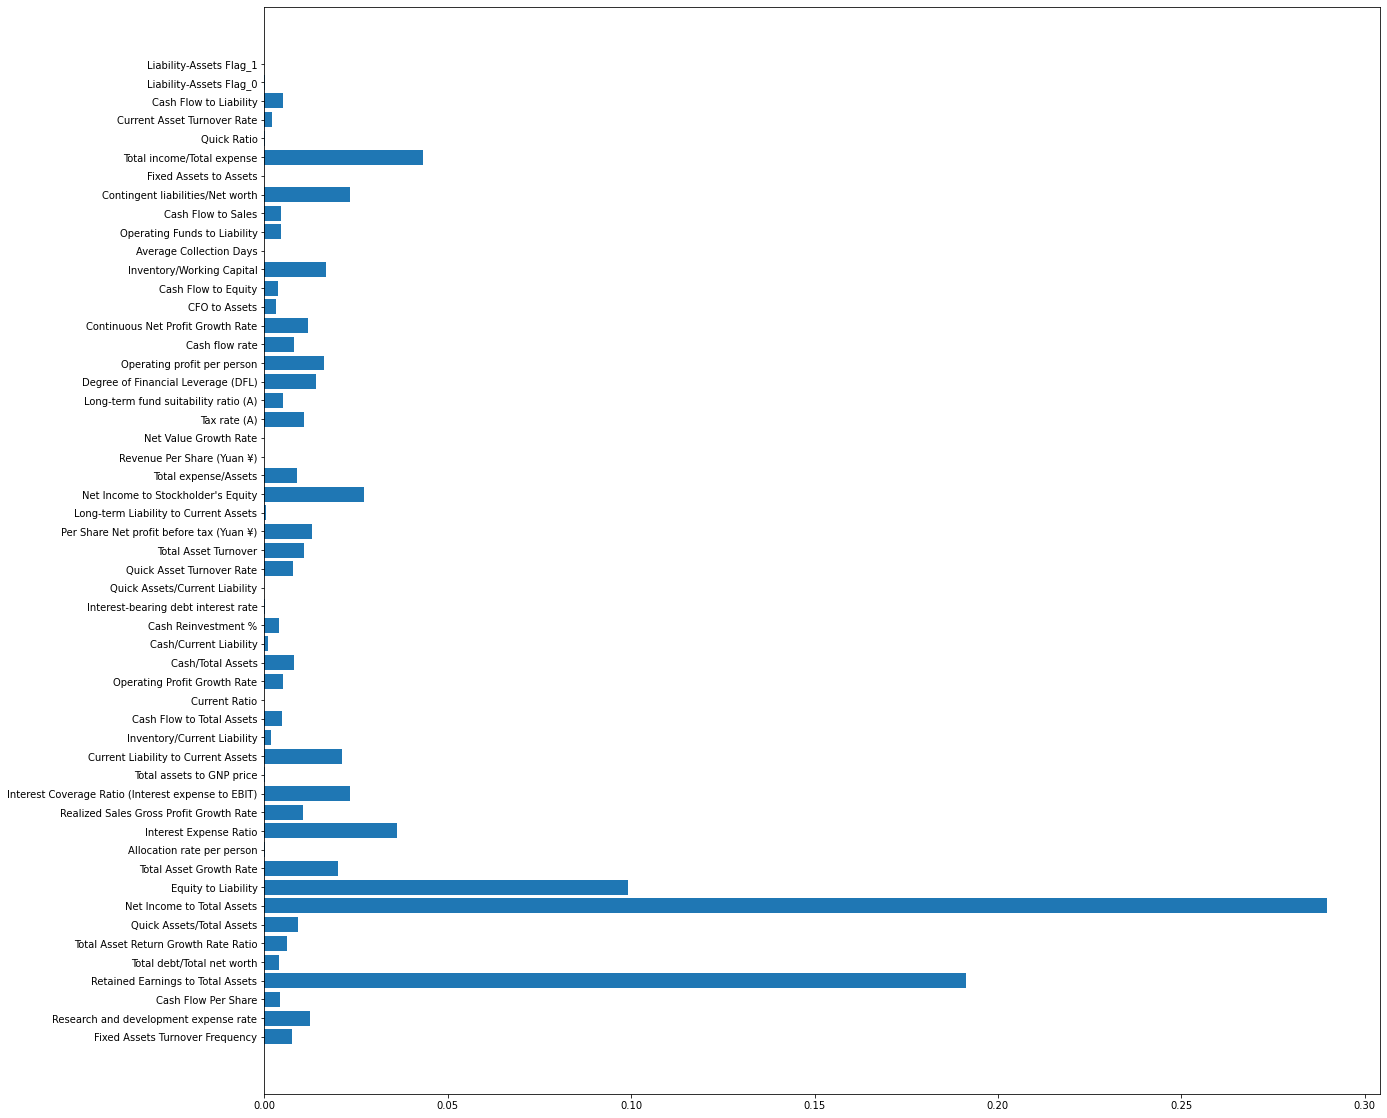

In [ ]:
plt.figure(figsize=(20,20))
plt.barh(list(X_validation.columns), rf_final.feature_importances_)

##### Shapley Value
*   게임 이론에 근거해서 만들어진 값 (https://ko.wikipedia.org/wiki/게임이론)
*   하나의 특성에 대한 중요도를 알기위해 여러 특성들의 조합을 구성하고 해당 특성의 유무에 따른 변화를 분석해서 얻어낸 값
*.  Explainable AI
*   https://en.wikipedia.org/wiki/Shapley_value



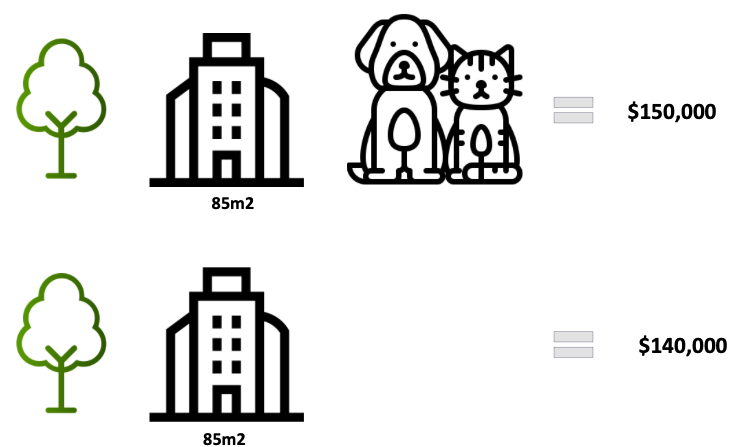

In [ ]:
Image(path_lecture + "img/shapley_value.png")

In [ ]:
# shapley value
explainer = shap.TreeExplainer(rf_final)

shap_values = explainer.shap_values(X_validation)

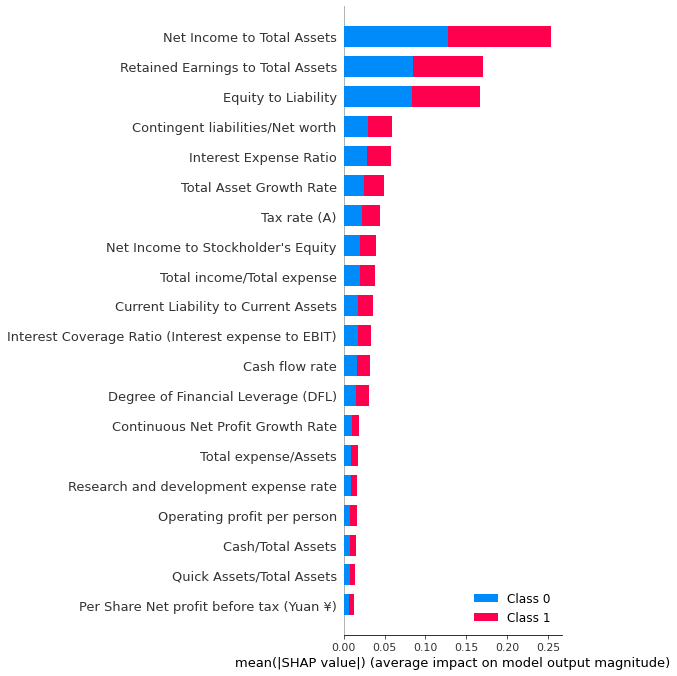

In [ ]:
shap.summary_plot(shap_values, X_validation)